In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import gc
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from utils import load_models, inference, save_model_w2w, save_model_for_diffusers
from sampling import sample_weights

device = "cuda:0"

## Load Files

1) mean is 99648 dimensional tensor of the mean for each parameter in the original LoRA space.
2) std is 99648 dimensional tensor of the standard deviation for each parameter in the original LoRA space.
3) v is 99648x10000 dimensional tensor used to project or unproject the weights onto principal component representation in w2w space or to unproject back into the LoRA space.
4) proj is a 64974x1000 dimensional tensor where each row is a 1000 dimensional principal component representation for each identity-encoding model in our dataset of weights.
5) df is a pandas dataframe with each identity model in our dataset of weights and their associated binary labels. 
6) weight_dimensions is a dictionary of the dimensionality for each LoRA in the UNet. Used to save models in Diffusers pipeline format. 

In [4]:
mean = torch.load("../files/mean.pt").bfloat16().to(device)
std = torch.load("../files/std.pt").bfloat16().to(device)
v = torch.load("../files/V.pt").bfloat16().to(device)
proj = torch.load("../files/proj_1000pc.pt").bfloat16().to(device)
df = torch.load("../files/identity_df.pt")
weight_dimensions = torch.load("../files/weight_dimensions.pt")

## Load Base Models

In [2]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


# Sample and Inference

To sample, we follow Sec. 3.2 from the paper. We sample each coefficient from a normal distribution for 1000 principal components. Each normal distribution uses the mean and standard deviation calculated for each componentn among all the training models. In the sampling function below, you can optionally increase or decrease the factor coefficient, which multiplies out the standard deviation. This increases or decreases the probability of sampling near the center of mass, affecting the diversity. 

In [4]:
# free up memory whenever we resample
if 'network' in globals():
    del network
    network = None
    gc.collect()
    torch.cuda.empty_cache() 
    unet, _, _, _, _ = load_models(device)

network  = sample_weights(unet, proj, mean, std, v[:, :1000], device, factor = 1.00)

100%|██████████| 51/51 [00:05<00:00,  9.00it/s]


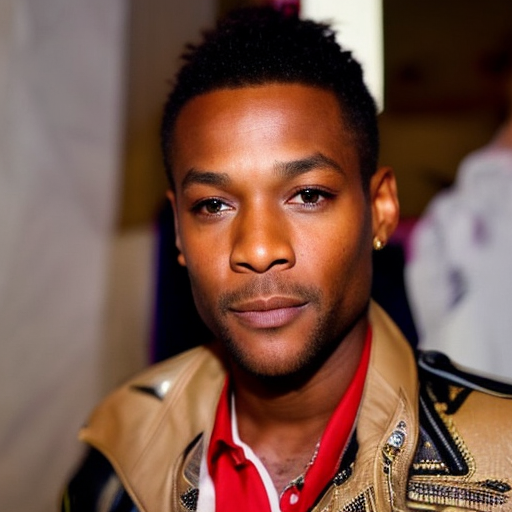

In [5]:
#inference parameters
prompt = "sks person" 
negative_prompt = "low quality, blurry, unfinished, cartoon" 
batch_size = 1
height = 512
width = 512
guidance_scale = 3.0
seed = 5
ddim_steps = 50
# random seed generator
generator = torch.Generator(device=device)

#run inference
image = inference(network, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, seed, generator, device)

### display image
image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image.show()

Save model (just the 1000 coefficients)

In [6]:
save_model_w2w(network, path="../output/sample1_w2w")

You can also save it in a format compatible with Diffusers pipelines

In [8]:
save_model_for_diffusers(network,std, mean, v[:, :1000], weight_dimensions, path="../output/sample1_diffusers")